In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from Project import Project

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from Scripts.neuralnets.NNTrainingUtils import train_autoencoder
from Scripts.neuralnets.NNPreinstalledModelSelection import *
from Scripts.neuralnets.NNTrainingUtils import train, kfold_train
from Scripts.data.SSVEPDataset import SSVEPDataset
from Scripts.data.SSVEPDataloader import SSVEPDataloader

In [4]:
ngpu = 1; device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

***

In [5]:
def read_data(dataframe):
    return torch.tensor(pd.read_csv(dataframe['path'], sep = ' ', header = None, dtype = float).values)

def dataVisualization(X1, X2, save = False, filename = None):
    fig, axs = plt.subplots(nrows = 2, ncols = 1)
    
    fig.set_size_inches(12, 5)
    fig.subplots_adjust(hspace = 0)
    
    for ax in axs:
        ax.xaxis.set_major_formatter(plt.NullFormatter())
        ax.yaxis.set_major_formatter(plt.NullFormatter())
    
    axs[0].imshow(X1, cmap = 'gray'); axs[0].set_title("Original")
    axs[1].imshow(X2, cmap = 'gray'); axs[1].set_title("Autoencoder's Output")
    
    if save: fig.savefig(filename)
    
    return fig, axs

def EncoderVisualization(model, data, save = False, filename = None):
    fig, ax = plt.subplots(nrows = 1, ncols = 1)
    fig.set_size_inches(15, 15)
    fig.tight_layout()
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.yaxis.set_major_formatter(plt.NullFormatter())
    
    image = model.encode(data).detach()[0]
    image = (image.transpose(0, 2).transpose(0, 1).numpy())
    ax.imshow(image)
    if save: fig.savefig(filename)
        
    return fig, ax

***

In [6]:
preprocessing = 'cca'
signal_length = '512'
data = pd.read_csv((Project.output_dir / ('SSVEPDataset_'+signal_length+'.csv')).__str__(), dtype = 'str')
dataset = SSVEPDataset(Project, preprocessing, data, signal_length)

In [7]:
batch_size = 128
dataloaders, dataset_sizes = SSVEPDataloader(dataset, batch_size)
print(dataset_sizes)

{'train': 2184, 'val': 546}


In [9]:
from Models.Autoencoder1 import Autoencoder

In [46]:
model = Autoencoder(kernel_n = 1, stride = 16).to(device)
summary(model, (1, 16, int(signal_length)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 1, 16, 32]               4
              ReLU-2            [-1, 1, 16, 32]               0
         MaxPool2d-3  [[-1, 1, 16, 16], [-1, 1, 16, 16]]               0
       BatchNorm2d-4            [-1, 1, 16, 16]               2
       MaxUnpool2d-5            [-1, 1, 16, 32]               0
   ConvTranspose2d-6           [-1, 1, 16, 512]               4
Total params: 10
Trainable params: 10
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 0.42
Params size (MB): 0.00
Estimated Total Size (MB): 0.46
----------------------------------------------------------------


In [47]:
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.5)

In [48]:
model, stats = train_autoencoder(Project, model, dataloaders, dataset_sizes, criterion, optimizer, num_epochs = 100)

[04/Oct/2020 03:45:08] INFO - Epoch    Stage       Loss  

[04/Oct/2020 03:45:08] INFO - 1/100    Training    1.12  
[04/Oct/2020 03:45:08] INFO -          Validation  1.09  
[04/Oct/2020 03:45:09] INFO - 2/100    Training    1.06  
[04/Oct/2020 03:45:09] INFO -          Validation  1.03  
[04/Oct/2020 03:45:09] INFO - 3/100    Training    1.01  
[04/Oct/2020 03:45:09] INFO -          Validation  1.00  
[04/Oct/2020 03:45:09] INFO - 4/100    Training    0.99  
[04/Oct/2020 03:45:09] INFO -          Validation  0.99  
[04/Oct/2020 03:45:10] INFO - 5/100    Training    0.98  
[04/Oct/2020 03:45:10] INFO -          Validation  0.98  
[04/Oct/2020 03:45:10] INFO - 6/100    Training    0.98  
[04/Oct/2020 03:45:10] INFO -          Validation  0.98  
[04/Oct/2020 03:45:10] INFO - 7/100    Training    0.98  
[04/Oct/2020 03:45:10] INFO -          Validation  0.98  
[04/Oct/2020 03:45:11] INFO - 8/100    Training    0.98  
[04/Oct/2020 03:45:11] INFO -          Validation  0.98  
[04/Oct/2020 

***

Visualization

In [20]:
exemplo = next(iter(dataloaders['train']))[0][0].unsqueeze(0).to(device)

In [21]:
output = model(exemplo).detach()

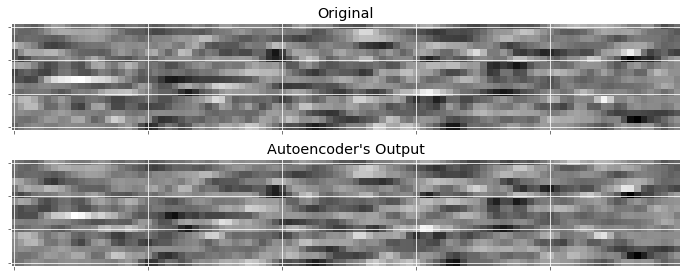

In [22]:
fig, ax = dataVisualization(exemplo.squeeze()[:, :100].cpu(), output.squeeze()[:, :100].cpu(), save = False, filename = "16x64_comparison.png")

[24/Sep/2020 15:48:56] WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


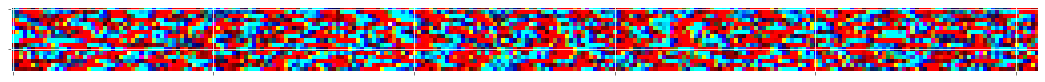

In [23]:
fig, ax = EncoderVisualization(model.cpu(), exemplo.cpu(), save = False, filename = '16x16_encoded.png')

***

Classification

In [49]:
class HybridModel(nn.Module):
    def __init__(self, classifier, encoder):
        super(HybridModel, self).__init__()
        self.encoder = encoder
        self.classifier = classifier
        
    def forward(self, x):
        with torch.set_grad_enabled(False):
            x = self.encoder(x)
        
        x = self.classifier(x)
        
        return x

In [50]:
model_type = 'resnet'; model_size = '18'; num_classes = 5; model_name = model_type + model_size
classifier = model_selection(model_name, num_classes)
classifier.conv1 = nn.Conv2d(1, 64, kernel_size = (7, 7), stride = (2, 2), padding = (3, 3), bias = False)
encoder = model.encoder
hybrid = HybridModel(classifier, encoder).to(device)

In [51]:
optimizer = optim.SGD(hybrid.parameters(), lr = 0.001, momentum = 0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.5)
criterion = nn.CrossEntropyLoss()

In [52]:
hybrid, stats = kfold_train(Project, hybrid, dataset, criterion, optimizer, num_epochs = 50, num_folds = 5)

[04/Oct/2020 03:45:52] INFO - Fold 0
[04/Oct/2020 03:45:52] INFO - Epoch    Stage       Loss    Accuracy

[04/Oct/2020 03:46:14] INFO - 1/50     Training    2.35    0.20    
[04/Oct/2020 03:46:16] INFO -          Validation  1.84    0.23    
[04/Oct/2020 03:46:38] INFO - 2/50     Training    2.17    0.21    
[04/Oct/2020 03:46:40] INFO -          Validation  2.19    0.15    
[04/Oct/2020 03:47:02] INFO - 3/50     Training    2.20    0.21    
[04/Oct/2020 03:47:04] INFO -          Validation  2.28    0.16    
[04/Oct/2020 03:47:26] INFO - 4/50     Training    2.19    0.21    
[04/Oct/2020 03:47:27] INFO -          Validation  2.48    0.22    
[04/Oct/2020 03:47:49] INFO - 5/50     Training    2.17    0.23    
[04/Oct/2020 03:47:51] INFO -          Validation  2.15    0.19    
[04/Oct/2020 03:48:13] INFO - 6/50     Training    2.11    0.21    
[04/Oct/2020 03:48:15] INFO -          Validation  2.09    0.22    
[04/Oct/2020 03:48:37] INFO - 7/50     Training    2.10    0.20    
[04/Oct/20

***